## Importing all the packages

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(ncols=50)

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, words
import regex as re

import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

import sklearn
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping, Callback

In [2]:
# import kagglehub
# path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
# print("Path to dataset files:", path)

In [3]:
df = pd.read_csv('twitter_training.csv', delimiter = ',', encoding = 'latin-1', header=None, names = ['Tweet_ID','Entity','sentiment','message'])

## Data Preprocessing

In [4]:
# df.sentiment.value_counts()

In [5]:
df['message'] = df['message'].astype('str')
sentiment = {'Negative':0, 'Neutral':1, 'Positive':2, 'Irrelevant':3}
df['sentiment'] = df['sentiment'].apply(lambda x: sentiment[x])
df.head(2)

,Tweet_ID,Entity,sentiment,message
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...
1,2401,Borderlands,2,I am coming to the borders and I will kill you...


[]

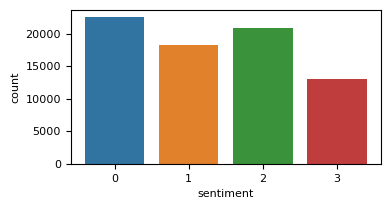

In [6]:
plt.figure(figsize=(4,2))
sns.barplot(x=df.sentiment.value_counts().index, y=df.sentiment.value_counts().values)
#plt.bar(x=df.sentiment.value_counts().index, height=df.sentiment.value_counts().values)
plt.xlabel('sentiment',fontsize = 8)
plt.ylabel('count',fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot()

In [7]:
def clean(text):
    #text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'http/S+',r'<url>',text)
    text = text.lower()
    text = re.sub(r'[\W+\d+_]', ' ', text)
    return text

df['message']=df['message'].apply(lambda x: clean(x))

In [8]:
dictionary_words = set(words.words())
def unwanted_words_clean(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = ' '.join(word for word in re.findall(r'\b\w+\b', text.lower()) if word in dictionary_words)
    return cleaned_text

df['message_TFIDF']=df['message'].apply(lambda x: unwanted_words_clean(x))

In [9]:
# The Tokenizer from Keras is used to convert text data into numerical sequences, which is essential for feeding text into neural networks. 
# num_words=500000: This specifies the maximum number of unique words to keep. The tokenizer will only consider the top 500,000 most frequent words from the dataset.

# Fit on Text: When you use tokenizer.fit_on_texts(), it scans through all the text data, creating a word index (mapping each word to an integer index).
# Text to Sequence: After fitting, when you use tokenizer.texts_to_sequences(), it converts the text data into sequences of integers where each word in the text is replaced by its corresponding index from the word index.
# Text to Matrix: The tokenizer can also convert text to a binary or TF-IDF matrix, depending on the mode used (via texts_to_matrix).

In [10]:
# word_counts = df['message_TFIDF'].str.split().explode().value_counts()

# word_counts_df = word_counts.reset_index()
# word_counts_df.columns = ['word', 'count']
# print(word_counts_df)

             word  count
0             the  44628
1               i  36423
2              to  29053
3             and  26712
4               a  24644
...           ...    ...
10399      outset      1
10400     bluntly      1
10401    hardship      1
10402  hesitation      1
10403         inn      1

[10404 rows x 2 columns]


In [ ]:
# plt.scatter(word_counts_df['count'].value_counts().keys(), word_counts_df['count'].value_counts().values)
# plt.ylim(0,1000)
# plt.xlim(0,5000)

## Tfidf Vectorizer

In [11]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_df = 6400, min_df = 10)
X_tfidf = tfidf.fit_transform(df['message_TFIDF'])

In [55]:
X_tfidf_dense = X_tfidf[:2].toarray()
tfidf_df = pd.DataFrame(X_tfidf_dense, columns=tfidf.get_feature_names_out())
#print(tfidf_df)

## Feature generation (Word embeddings by traing Doc2Vec model)

In [21]:
def word_tokenize(text):
    tokens=[]
    for word in nltk.word_tokenize(text):
            tokens.append(word)
    return set(tokens)
    
df_tagged = df.apply(lambda x: TaggedDocument(words=word_tokenize(x['message']), tags = [x['sentiment']]), axis = 1)

In [22]:
tokenizer = Tokenizer(num_words=500000, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['message'].values)
X = tokenizer.texts_to_sequences(df['message'].values)
X= pad_sequences(X, maxlen=20)

In [23]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, min_count = 1, window = 8, vector_size = 300, alpha = 0.01, workers = -1)
d2v_model.build_vocab([x for x in tqdm(df_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2310073.32it/s]


In [24]:
for i in range(150):
    d2v_model.train(utils.shuffle([x for x in tqdm(df_tagged.values)]), total_examples = len(df_tagged.values), epochs = 15)
    print(d2v_model.alpha)

#d2v model helps get the initial embeddings which the input data might find useful in understanding the contents like happy is similar to joy.

100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2339892.07it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 488226.07it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1109556.91it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 933181.03it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1904095.92it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1051448.12it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 631474.25it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1355121.35it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1842614.94it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 850924.74it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1822375.49it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2117137.84it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1713364.50it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1113232.06it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3362701.54it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2003985.79it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1928882.91it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2031289.18it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 932917.00it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1906297.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1746689.18it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1521545.31it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1189774.27it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3038412.03it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3204819.02it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2595229.51it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1592900.03it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390206.95it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390498.81it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 796603.95it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2391046.23it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1145599.61it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 949856.75it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1029707.27it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389696.38it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2388730.53it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390170.48it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389222.47it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1592964.83it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 849980.36it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389550.54it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389714.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389550.54it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1195231.16it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390006.34it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4784758.67it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389732.84it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2388366.26it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389787.53it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4783443.46it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2391959.16it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1593499.67it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389732.84it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 390359.63it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1566257.71it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389678.15it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389258.91it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2388821.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1195089.80it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1593086.35it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389204.24it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1592940.53it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 785897.29it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1589118.09it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2391046.23it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1593507.78it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390243.43it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4189479.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2388730.53it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2293564.70it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2391009.73it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389860.47it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1194925.67it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 926432.91it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2325888.33it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2388821.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1172130.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4756928.90it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390681.25it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 682847.05it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 526073.70it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3932841.30it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2547300.63it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2406846.30it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3702982.72it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2382589.27it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2294640.00it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2369809.21it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1180341.44it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2385020.19it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2240205.77it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1359125.49it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390371.11it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389896.93it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390663.01it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1194912.00it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1843699.48it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4176241.73it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389477.62it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1593240.31it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1579964.45it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2736596.20it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4003975.50it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2388694.09it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2519618.82it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4767354.26it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1911684.18it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1617176.55it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2339594.96it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2361109.94it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4635358.87it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2283515.91it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389824.00it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390334.63it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4781544.98it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 325030.80it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390352.87it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 955868.34it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390042.81it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389714.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389459.40it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390225.19it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4778335.59it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4577443.14it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 525754.94it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1195067.00it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390334.63it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389058.46it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2391356.55it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390954.98it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 955917.93it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1852520.65it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390371.11it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1204468.94it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2416445.61it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2023141.88it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4716389.54it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4484324.16it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2300504.63it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4965112.40it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4163751.31it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3630115.21it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2390206.95it/s]


0.01


100%|████████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 955941.27it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389696.38it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 4776077.02it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 2389076.68it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1012483.19it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 1649842.05it/s]


0.01


100%|███████████████████████████████████████████████████████████████████████| 74682/74682 [00:00<00:00, 3031707.12it/s]


0.01


In [25]:
d2v_model.save("doc2vec_model.d2v")
# d2v_model = Doc2Vec.load("doc2vec_model.d2v")

In [ ]:
# import gensim.downloader as api
# wv = api.load('word2vec-google-news-300')

In [26]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    if word in d2v_model.wv.key_to_index:
        embedding_matrix[i] = d2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(300,))

In [27]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)

## Naive Bayes

In [14]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)

In [19]:
model = GaussianNB()
model.fit(X_train_tfidf.toarray(), y_train_tfidf)  # Convert to dense array if X_tfidf is sparse
predictions = model.predict(X_test_tfidf.toarray())
predictions

array([3, 2, 0, ..., 2, 0, 1], dtype=int64)

In [59]:
def get_scores(preds, Y):
    print('F1_score', f1_score(Y, preds, average = 'macro'))
    print('recall_score', recall_score(Y, preds, average = 'macro'))
    print('accuracy_score', accuracy_score(Y, preds))

In [60]:
get_scores(predictions, y_test_tfidf)

F1_score 0.6522074650951457
recall_score 0.6687021231705488
accuracy_score 0.647921269331191


## LSTM

In [28]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 300, weights = embedding_matrix, trainable =True)) 
model.add(LSTM(32, return_sequences = True, dropout=0.2, recurrent_dropout=0.3))
model.add(LSTM(32, return_sequences = False, dropout=0.2, recurrent_dropout=0.3))
# model.add(LSTM(16, return_sequences = False, activation='tanh'))
model.add(Dense(4, activation='tanh'))

In [29]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['recall'])

In [30]:
cb = [EarlyStopping(patience = 4, min_delta = 0.001, monitor = 'val_loss')]
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_split = 0.15, validation_freq = 1, verbose = 2, callbacks = cb)

Epoch 1/50
1687/1687 - 118s - 70ms/step - loss: 0.4595 - recall: 0.4043 - val_loss: 0.3703 - val_recall: 0.6417
Epoch 2/50
1687/1687 - 138s - 82ms/step - loss: 0.2997 - recall: 0.7408 - val_loss: 0.3093 - val_recall: 0.7434
Epoch 3/50
1687/1687 - 108s - 64ms/step - loss: 0.2179 - recall: 0.8172 - val_loss: 0.3067 - val_recall: 0.7849
Epoch 4/50
1687/1687 - 110s - 65ms/step - loss: 0.1902 - recall: 0.8493 - val_loss: 0.2731 - val_recall: 0.8034
Epoch 5/50
1687/1687 - 111s - 66ms/step - loss: 0.1678 - recall: 0.8668 - val_loss: 0.2705 - val_recall: 0.8199
Epoch 6/50
1687/1687 - 109s - 65ms/step - loss: 0.1379 - recall: 0.8854 - val_loss: 0.2612 - val_recall: 0.8429
Epoch 7/50
1687/1687 - 108s - 64ms/step - loss: 0.1415 - recall: 0.8947 - val_loss: 0.2771 - val_recall: 0.8317
Epoch 8/50
1687/1687 - 107s - 64ms/step - loss: 0.1277 - recall: 0.9038 - val_loss: 0.2664 - val_recall: 0.8403
Epoch 9/50
1687/1687 - 104s - 61ms/step - loss: 0.1086 - recall: 0.9102 - val_loss: 0.2854 - val_recall:

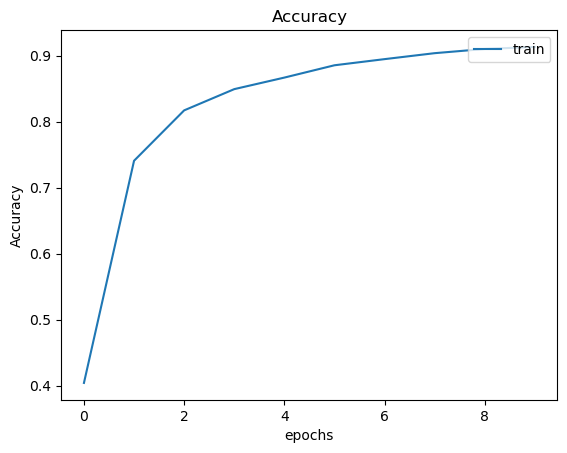

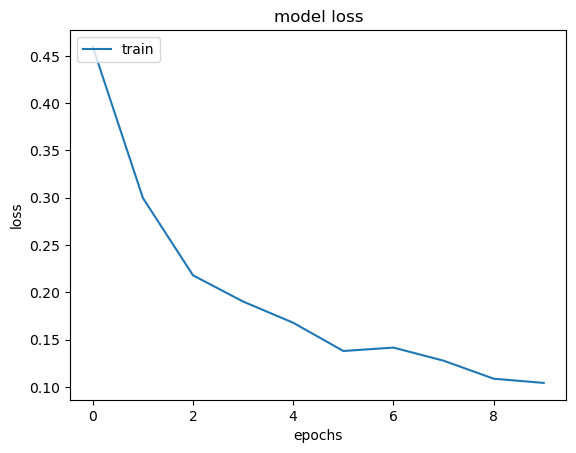

In [31]:
plt.plot(history.history['recall'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train'], loc= 'upper right')
plt.show()

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
_, train_acc = model.evaluate(X_train, Y_train)
_, test_acc = model.evaluate(X_test, Y_test)
print(f'(train_acc {train_acc}, test_acc {test_acc})')

1984/1984 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0790 - recall: 0.9254
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3052 - recall: 0.8418
(train_acc 0.9154523611068726, test_acc 0.8487905263900757)


In [33]:
predicted_classes = [np.argmax(i) for i in model.predict(X_test, verbose = 0)]
true_classes = [np.argmax(i) for i in Y_test]

In [51]:
print('F1_score', f1_score(true_classes, predicted_classes, average = 'macro'))
print('recall_score', recall_score(true_classes, predicted_classes, average = 'macro'))
print('accuracy_score', accuracy_score(true_classes, predicted_classes))

F1_score 0.8588161872687623
recall_score 0.8543747795526074
accuracy_score 0.860037489958047


In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_classes, predicted_classes)

array([[2977,   94,  255,   79],
       [ 160, 2235,  215,   58],
       [ 159,  110, 2828,   70],
       [ 110,   64,  194, 1595]], dtype=int64)

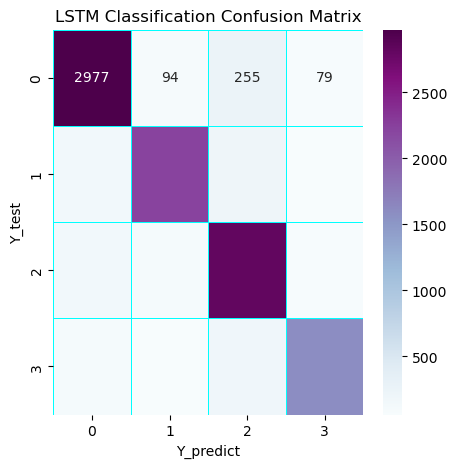

In [36]:
import seaborn as sns
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot= True, linewidth = 0.7, linecolor = 'cyan', fmt = 'g', ax=ax, cmap = 'BuPu')
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y_predict')
plt.ylabel('Y_test')
plt.show()

In [38]:
model.save("model.keras")
#loaded_model = keras.saving.load_model("model.keras")

# import pickle
# with open('LSTM.pkl','wb') as file:
#     pickle.dump(model, file)

## Gradient Boosting Classifier

In [57]:
# gbclassifier = GradientBoostingClassifier(loss = 'log_loss', validation_fraction = 0.1, subsample = 0.8, tol = 4, learning_rate = 0.4, n_estimators = 4000, verbose = 2, max_features = None, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2)
# gbclassifier.fit(X_train, Y_tr)

In [56]:
# gbclassifier_pred =gbclassifier.predict(X_test)

In [ ]:
# get_scores(gbclassifier_pred, Y_tst)

## XGBClassifier

In [41]:
Y_tr = [np.argmax(i) for i in Y_train]
Y_tst = [np.argmax(i) for i in Y_test]

In [39]:
cutoff_eval = int(0.8*len(X_train))

In [42]:
X_train_non_eval = X_train[:cutoff_eval]
Y_tr_non_eval = Y_tr[0:cutoff_eval]

X_eval = X_train[cutoff_eval:]
Y_eval = Y_tr[cutoff_eval:]

In [43]:
xgb = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_features = None, max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_jobs = -1, early_stopping_rounds = 4)
xgb.fit(X_train_non_eval, Y_tr_non_eval, eval_set = [(X_eval, Y_eval)])

[0]	validation_0-mlogloss:1.36692


C:\Users\tanvi\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:1.35019
[2]	validation_0-mlogloss:1.33465
[3]	validation_0-mlogloss:1.32112
[4]	validation_0-mlogloss:1.30852
[5]	validation_0-mlogloss:1.29654
[6]	validation_0-mlogloss:1.28617
[7]	validation_0-mlogloss:1.27595
[8]	validation_0-mlogloss:1.26679
[9]	validation_0-mlogloss:1.25707
[10]	validation_0-mlogloss:1.24906
[11]	validation_0-mlogloss:1.24113
[12]	validation_0-mlogloss:1.23405
[13]	validation_0-mlogloss:1.22735
[14]	validation_0-mlogloss:1.21967
[15]	validation_0-mlogloss:1.21319
[16]	validation_0-mlogloss:1.20694
[17]	validation_0-mlogloss:1.19956
[18]	validation_0-mlogloss:1.19395
[19]	validation_0-mlogloss:1.18734
[20]	validation_0-mlogloss:1.18179
[21]	validation_0-mlogloss:1.17672
[22]	validation_0-mlogloss:1.17117
[23]	validation_0-mlogloss:1.16631
[24]	validation_0-mlogloss:1.16090
[25]	validation_0-mlogloss:1.15620
[26]	validation_0-mlogloss:1.15119
[27]	validation_0-mlogloss:1.14729
[28]	validation_0-mlogloss:1.14372
[29]	validation_0-mlogloss:1.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=4,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_features=None,
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, ...)

In [44]:
xgb_pred =xgb.predict(X_test)

In [47]:
get_scores(xgb_pred, Y_tst)

F1_score 0.7243422483661676
recall_score 0.7168206040989249
accuracy_score 0.7319467999642952


## Voting Classifier

In [53]:
from sklearn.ensemble import VotingClassifier

def custom_VotingClassifier():
    final_preds = []
    for i in range(len(X_test)):
        preds = [xgb_pred[i], predictions[i], predicted_classes[i]]
        final_preds.append(np.bincount(preds).argmax())
    return final_preds, preds

In [62]:
final_preds, preds = custom_VotingClassifier()
get_scores(final_preds, Y_tst)

F1_score 0.8524295085261946
recall_score 0.8463031066707667
accuracy_score 0.8534321163973936
